In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from sklearn.model_selection import train_test_split

import shutil

from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-03-19 21:40:41.502974: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 21:40:41.503176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 21:40:41.690363: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# !kaggle datasets download -d robertmk94/deeplearning

In [3]:
# Extra cell to check the image size

from PIL import Image

example_image_path = "/kaggle/input/deeplearning/augmented/all_data/angry/angry_im0000.png"

with Image.open(example_image_path) as img:
    image_width, image_height = img.size

print("Image Width:", image_width)
print("Image Height:", image_height)

Image Width: 48
Image Height: 48


In [4]:
BATCH_SIZE = 128
IMG_SIZE = (48, 48)

EPOCHS = 20 # EPOCHS
EARLY_STOP = 10 # SET THE EARLY STOP NUMBER FOR CALLBACK
SUBSET_FRACT = 1 # SCALES THE BATCH SIZE, (ex: 128 * 0.5 = 256, batch size = 256)

# Initialize
datagen = ImageDataGenerator(validation_split=0.2)
data_dir = '/kaggle/input/deeplearning/augmented/all_data'

# Prepare Generators
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(48, 48),
    batch_size=int(BATCH_SIZE * SUBSET_FRACT),  # Adjusted batch size
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(48, 48),
    batch_size=int(BATCH_SIZE * SUBSET_FRACT),  # Adjusted batch size
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

Found 28755 images belonging to 6 classes.
Found 7185 images belonging to 6 classes.


### Visualizing Data

In [5]:
class_indices = train_generator.class_indices
class_names = dict((v, k) for k, v in class_indices.items())
class_names

{0: 'angry', 1: 'fearful', 2: 'happy', 3: 'neutral', 4: 'sad', 5: 'surprised'}

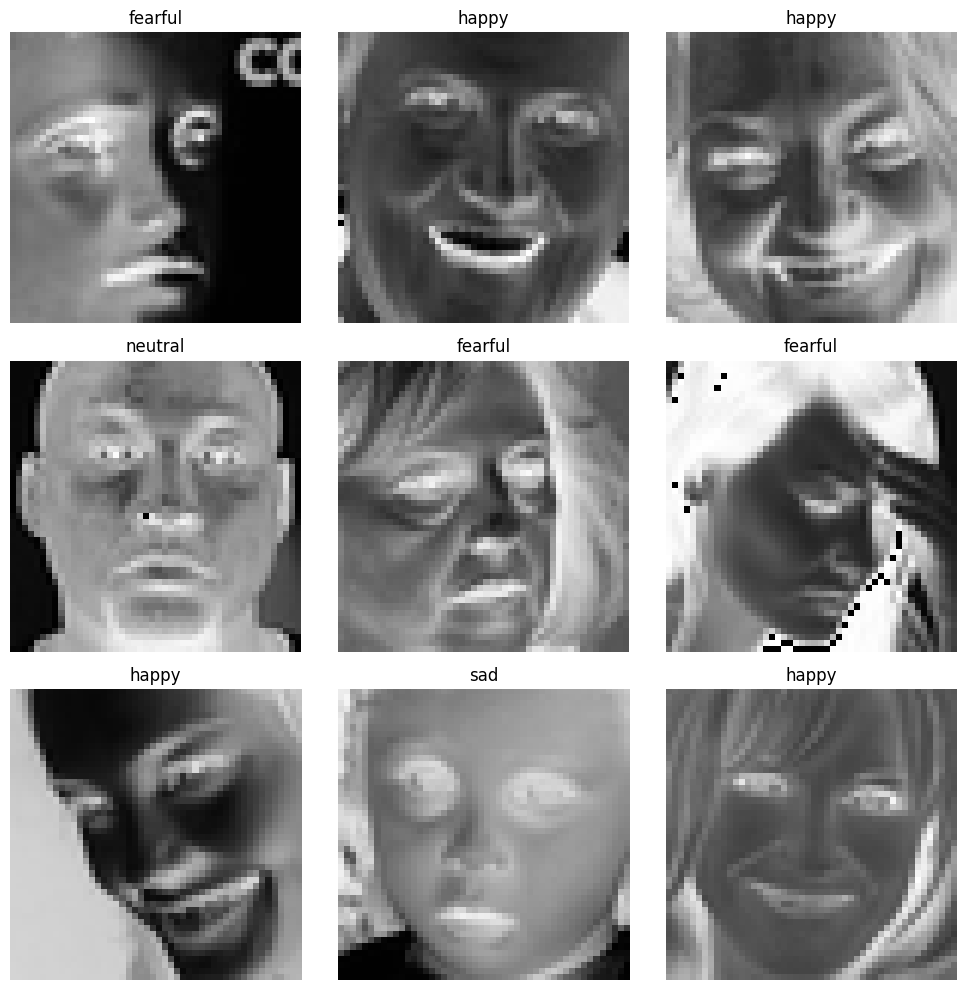

In [6]:
sample_images, sample_labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):  # Plot 9 sample images
    plt.subplot(3, 3, i + 1)
    plt.imshow((sample_images[i] * 255).astype(np.uint8))  # Rescale pixel values to [0, 255]
    plt.title(class_names[np.argmax(sample_labels[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()

# ResNet Architecture

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow import keras

In [8]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
for layer in resnet.layers:
    layer.trainable = False

In [10]:
model = Sequential()
# Input layer for your resized images
model.add(tf.keras.layers.Input(shape=(48, 48, 3))) 
# Resize images
model.add(tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (image_height, image_width))))  
# Add resnet model
model.add(resnet)
# Flatten the output of the resnet model
model.add(Flatten())
# Add custom dense layers
model.add(Dense(64, activation='tanh'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))  # Dropout layer with 50% dropout rate
model.add(Dense(6, activation='softmax'))  # 6 classes for your dataset

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,154,950 (92.14 MB)

 Trainable params: 567,238 (2.16 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
epochs = 50

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    verbose=1
)

### Predicting with random images

In [14]:
from tensorflow.keras.preprocessing import image

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[0.74734896 0.04896756 0.01953176 0.06040783 0.1210543  0.0026896 ]]
Predicted class: 0


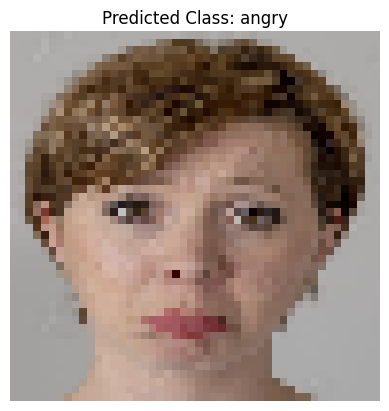

In [15]:
uploaded_image_path = '/kaggle/input/test-images-dl2/test_image_06.jpg'

img = image.load_img(uploaded_image_path, target_size=(48, 48))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0 

# Make predictions
predictions = model.predict(img_array)
print(predictions)

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Print the predicted class label
print("Predicted class:", predicted_class)

predicted_class_index = np.argmax(predictions)
predicted_class_name = class_names[predicted_class_index]
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_name}')
plt.show()

# ['angry', 'fearful', 'happy', 'neutral', 'sad', 'surprised']